In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from multiprocessing import Pool
from tqdm import tqdm
from datetime import datetime
import sys
sys.path.append('../src')

from graph_utils import *
from performance_utils import *
from metropolis import *
from houdayer_algorithm import *
from sim_util import *

In [2]:
# Define the parameters
N = 100     # number of nodes
d = 5       # degree
r = 0.1    # b/a

a, b, _ = generate_detectable_a_b(d, r)
display_spec(N, d, a, b, r)

Specs:
  Number of nodes (N) = 100
  Degree of graph (d) = 5
  Intra-group connect param (a) = 9.09090909090909
  Inter-group connect param (b) = 0.9090909090909091
  Group connect ratio (r) = b/a = 0.1
  Critical ratio (rc) = 0.38196601125010515 (for detectable communities)


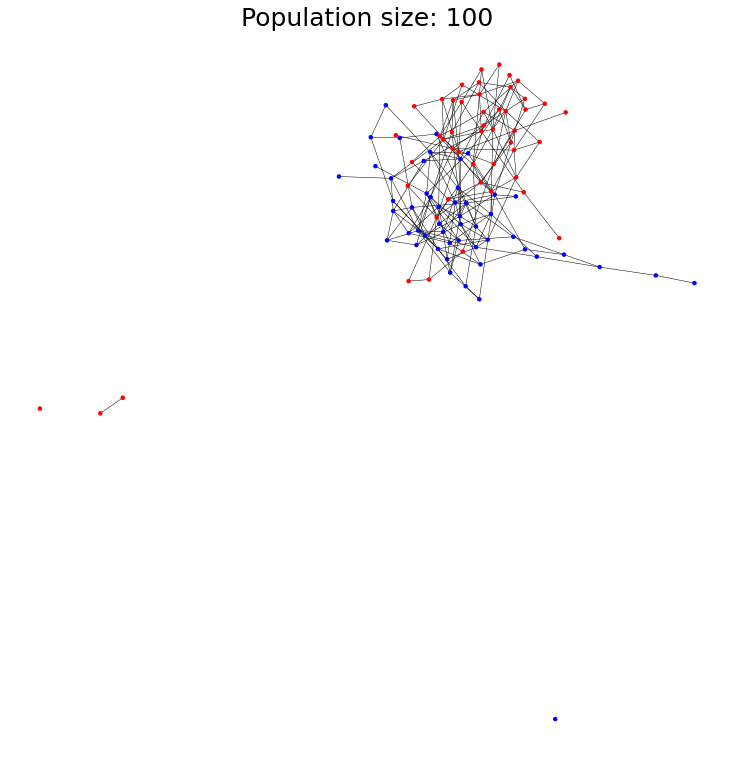

In [3]:
# Initialize random seed
#np.random.seed(0)

# Generate random state
x_star = generate_population(N)
G = graph_gen(x_star, a, b)
A = nx.to_numpy_array(G)

draw_graph(G, x_star)

# Simulations

In [4]:
nexp = 100  # Number of experiments
T = 10000   # Number of steps

## Metropolis

In [2]:
# Needed so that each process has its own RNG
def set_seed():
    np.random.seed()

def run_metropolis_single(args):
    A, a, b, T = args
    q = []
    mc = Metropolis(A, a, b)
    for i in range(T):
        mc.step()
        q.append(compute_overlap(x_star, mc.x))
    return q

def run_metropolis(A, a, b, T, num_exp):
    # Run experiments in parallel
    qs = []
    args = [(A, a, b, T) for i in range(num_exp)]
    with Pool(initializer=set_seed) as p:
        with tqdm(total=num_exp) as pbar:
            for q in p.imap_unordered(run_metropolis_single, args):
                pbar.update()
                qs.append(q)
    return np.array(qs)

In [6]:
def draw_plots(Q):
    plt.figure(figsize=(12,9))
    plt.plot(Q[:,-1])
    plt.xlabel('Experiment')
    plt.ylabel('q')
    plt.title('Limiting Overlap Over Expermients');
    
    avg = np.average(Q, axis=0)
    plt.figure(figsize=(12,9))
    plt.plot(avg)
    plt.xlabel('t')
    plt.ylabel('q')
    #plt.ylim(top=1.)
    plt.grid()
    plt.title('Average Overlap Over Time');
    
    print(f'Average limiting overlap: {avg[-1]:.4f}')

In [7]:
Q = run_metropolis(A, a, b, T, nexp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.53it/s]


Average limiting overlap: 0.9340


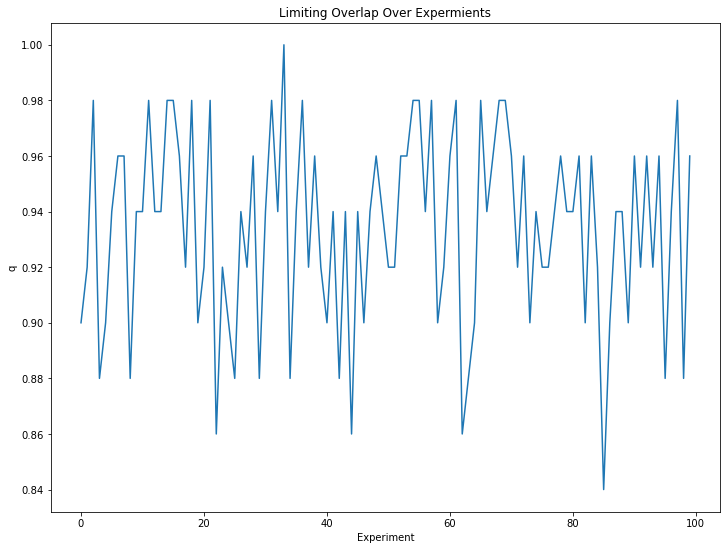

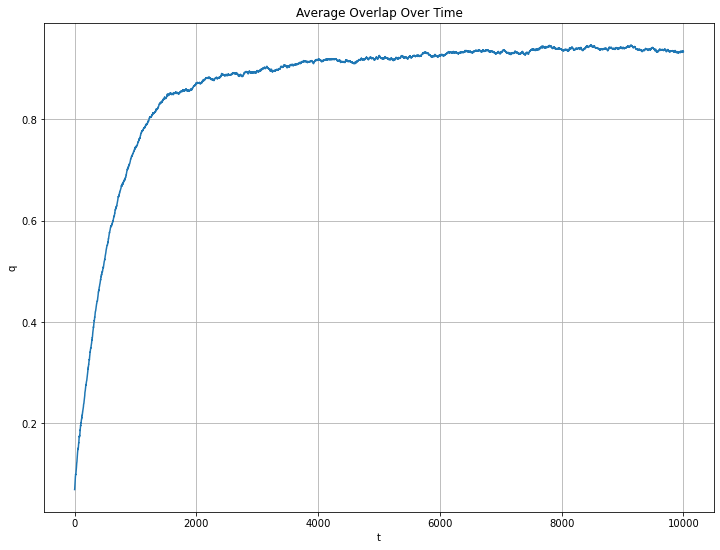

In [8]:
draw_plots(Q)

## Houdayer-1 

In [9]:
def run_houdayer_single(args):
    A, a, b, T, n0 = args
    q1 = []
    q2 = []
    mc1 = Metropolis(A, a, b)
    mc2 = Metropolis(A, a, b)
    for i in range(T):
        if i % n0 == 0:
            # Houdayer step
            mc1.x, mc2.x = houdayer_step(G, mc1.x, mc2.x)
        mc1.step()
        mc2.step()
        q1.append(compute_overlap(x_star, mc1.x))
        q2.append(compute_overlap(x_star, mc2.x))
    return q1, q2

def run_houdayer(A, a, b, T, num_exp, n0):
    # Run experiments in parallel
    q1s = []
    q2s = []
    args = [(A, a, b, T, n0) for i in range(num_exp)]
    with Pool(initializer=set_seed) as p:
        with tqdm(total=num_exp) as pbar:
            for q1, q2 in p.imap_unordered(run_houdayer_single, args):
                pbar.update()
                q1s.append(q1)
                q2s.append(q2)
    return np.array(q1s), np.array(q2s)

In [10]:
Q1, Q2 = run_houdayer(A, a, b, T, nexp, n0=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:56<00:00,  1.16s/it]


Average limiting overlap: 0.9342


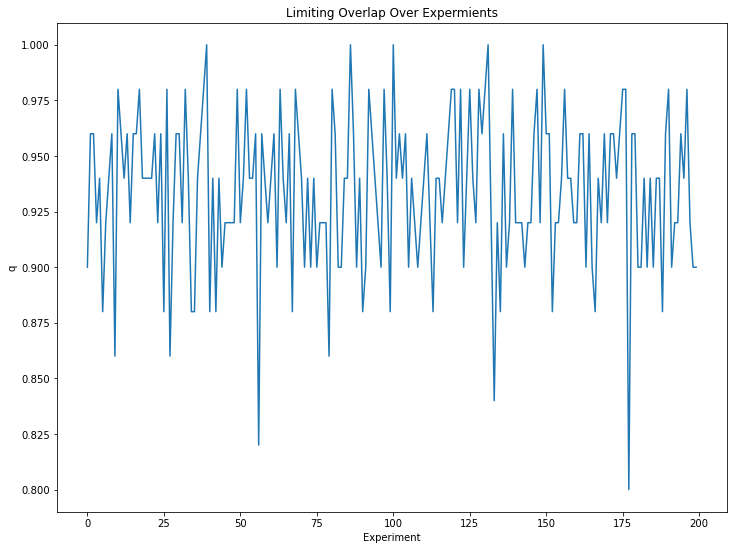

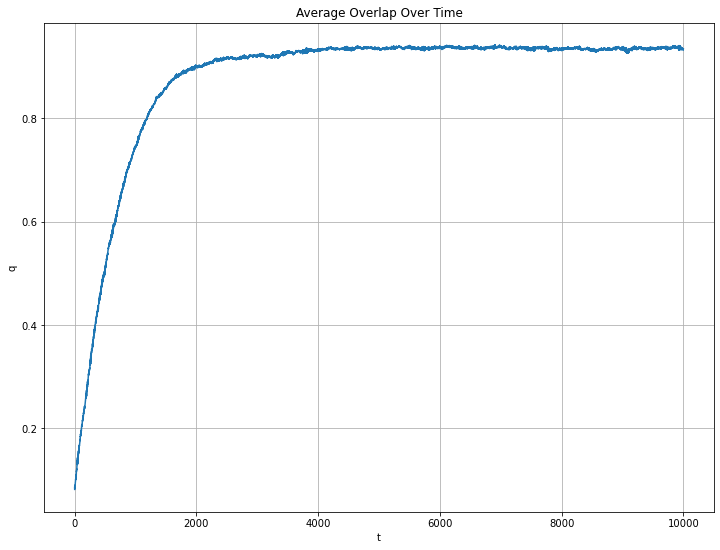

In [11]:
Q = np.vstack((Q1, Q2))
draw_plots(Q)

## Houdayer-10

In [12]:
Q1, Q2 = run_houdayer(A, a, b, T, nexp, n0=10)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:23<00:00,  4.34it/s]


Average limiting overlap: 0.9372


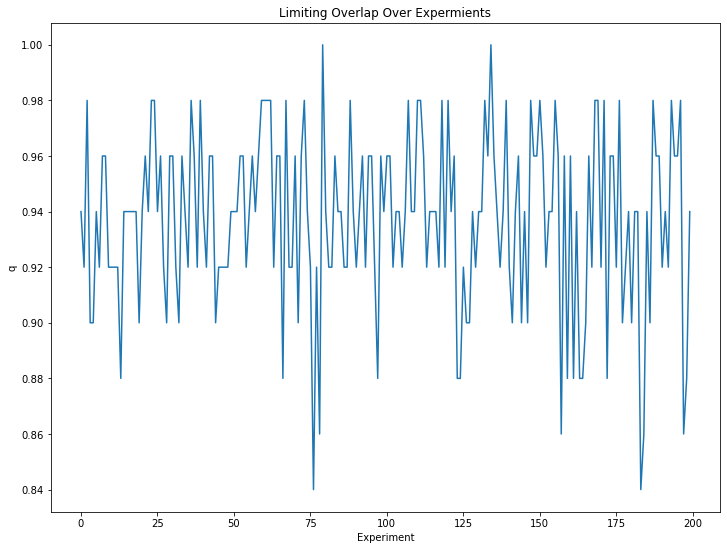

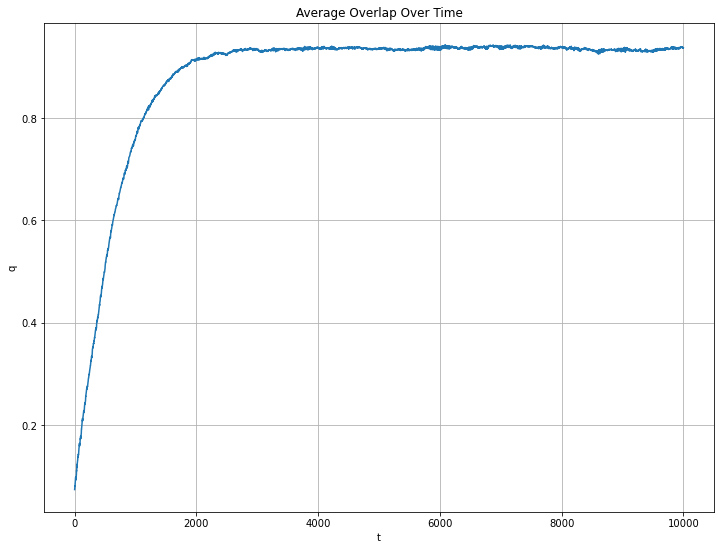

In [13]:
Q = np.vstack((Q1, Q2))
draw_plots(Q)

## Computing the Convergence time of the different algorithms

In [14]:
def conv_time_metropolis_single(args):
    A, a, b = args
    mc = Metropolis(A, a, b)
    T = 0
    while 1 - compute_overlap(x_star, mc.x) >= epsilon:
        mc.step()
        T += 1
    return T

def conv_time_houdayer_single(args):
    A, a, b, n0 = args
    mc1 = Metropolis(A, a, b)
    mc2 = Metropolis(A, a, b)
    T = 0
    while 1 - (compute_overlap(x_star, mc1.x) + compute_overlap(x_star, mc2.x)) / 2 >= epsilon:
        if T % n0 == 0:
            # Houdayer step
            x1, x2 = houdayer_step(G, mc1.x, mc2.x)
            mc1.x = x1
            mc2.x = x2
        # Metropolis step
        mc1.step()
        mc2.step()
        T += 1
    return T

def conv_time_metropolis(A, a, b, num_exp):
    # Run experiments in parallel
    Ts = []
    args = [(A, a, b) for i in range(num_exp)]
    with Pool(initializer=set_seed) as p:
        with tqdm(total=num_exp) as pbar:
            for T in p.imap_unordered(conv_time_metropolis_single, args):
                pbar.update()
                Ts.append(T)
    return round(sum(Ts) / num_exp)

def conv_time_houdayer(A, a, b, num_exp, n0):
    # Run experiments in parallel
    Ts = []
    args = [(A, a, b, n0) for i in range(num_exp)]
    with Pool(initializer=set_seed) as p:
        with tqdm(total=num_exp) as pbar:
            for T in p.imap_unordered(conv_time_houdayer_single, args):
                pbar.update()
                Ts.append(T)
    return round(sum(Ts) / num_exp)

Specs:
  Number of nodes (N) = 1000
  Degree of graph (d) = 3
  Intra-group connect param (a) = 5.714285714285714
  Inter-group connect param (b) = 0.28571428571428575
  Group connect ratio (r) = b/a = 0.05
  Critical ratio (rc) = 0.2679491924311227 (for detectable communities)


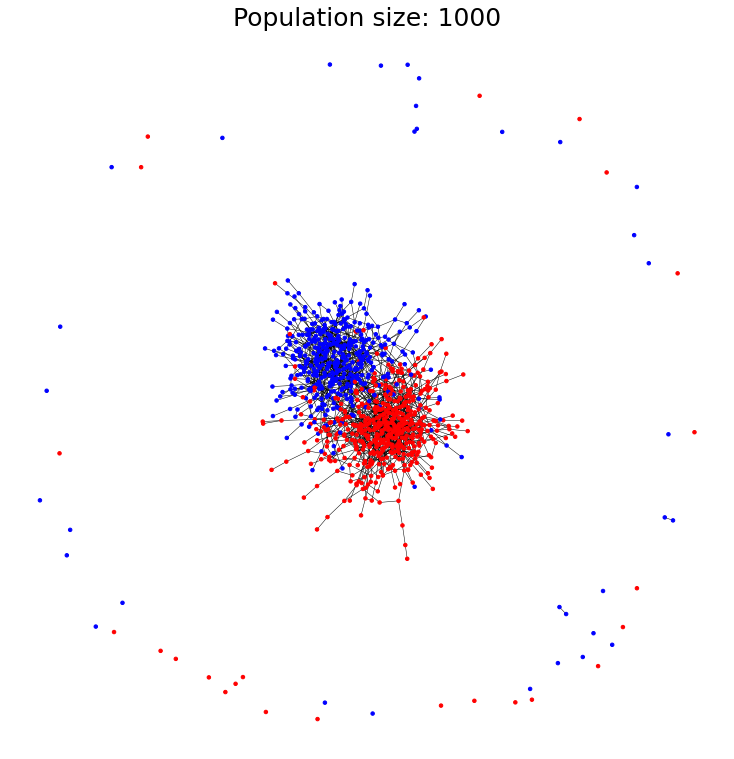

In [202]:
# Parameters
N = 1000
d = 3
r = 0.05
a, b, _ = generate_detectable_a_b(d, r)
display_spec(N, d, a, b, r)

# random population and graph
x_star = generate_population(N)
G = graph_gen(x_star, a, b)
A = nx.to_numpy_array(G)

draw_graph(G, x_star)

In [203]:
epsilon = 0.1 # precision required for convergence
nexp_conv = 100

print("Convergence time for Metropolis: {}".format(conv_time_metropolis(A, a, b, nexp_conv)))
#print("Convergence time for Houdayer 1: {}".format(conv_time_houdayer(A, a, b, nexp_conv, n0=1)))
#print("Convergence time for Houdayer 10: {}".format(conv_time_houdayer(A, a, b, nexp_conv, n0=10)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.01it/s]

Convergence time for Metropolis: 138785


## Limiting performance for different values of r (Metropolis)

In [3]:
def rplot_metropolis_single(x_star, A, a, b, T):
    mc = Metropolis(A, a, b)
    mc.step(T)
    return compute_overlap(x_star, mc.x)

def rplot_houdayer_single(x_star, G, A, a, b, T, n0):
    mc1 = Metropolis(A, a, b)
    mc2 = Metropolis(A, a, b)
    for i in range(T):
        if i % n0 == 0:
            # Houdayer step
            x1, x2 = houdayer_step(G, mc1.x, mc2.x)
            mc1.x = x1
            mc2.x = x2
        # Metropolis step
        mc1.step()
        mc2.step()
        
    overlap1 = compute_overlap(x_star, mc1.x)
    overlap2 = compute_overlap(x_star, mc2.x)
    return overlap1, overlap2

def rplot_mixed(N, d, T, n0, r_list, num_xstar, num_graph, num_exp):
    with Pool(initializer=set_seed) as p:
        ################################################################################
        # Queue jobs
        ################################################################################
        print('Queueing jobs:')
        results = []
        total_runs = len(r_list) * num_xstar * num_graph * num_exp
        with tqdm(total=total_runs) as pbar:
            for r in r_list:
                # Compute connectivity parameters
                a = 2. * d / (1. + r)
                b = a * r
                results_r = []

                for i in range(num_xstar):
                    # Generate ground truth
                    x_star = generate_population(N)

                    for j in range(num_graph):
                        # Generate observation graph
                        G = graph_gen(x_star, a, b)
                        A = nx.to_numpy_array(G)

                        for k in range(num_exp):
                            # Run experiment
                            if n0 == 0:
                                res = p.apply_async(rplot_metropolis_single, (x_star, A, a, b, T))
                            else:
                                res = p.apply_async(rplot_houdayer_single, (x_star, G, A, a, b, T, n0))
                            results.append(res)
                            pbar.update()
        
        ################################################################################
        # Fetch results
        ################################################################################
        print('Fetching results:')
        overlaps = []
        with tqdm(total=total_runs) as pbar:
            for res in results:
                if n0 == 0:
                    overlaps.append(res.get())
                else:
                    qs = res.get()
                    overlaps.append(qs[0])
                    overlaps.append(qs[1])
                pbar.update()
        
        # Reshape into matrix
        if n0 > 0:
            num_exp *= 2
        Q = np.array(overlaps)
        Q = Q.reshape(len(r_list), num_xstar, num_graph, num_exp)
                
    return Q

In [4]:
# Problem parameters
d = 5
r_c = critical_ratio(d)
print(f'r_c = {r_c:.4f}')

# Simulation paramters
T = 32000       # Number of steps
num_xstar = 10  # Number of ground truths
num_graph = 10  # Number of graphs
num_exp = 1     # Number of experiments

# Values of N to be tested
N_list = [100, 500, 1000]

# Values of r to be tested
r_list = np.linspace(0.01, 1, num=10, endpoint=False)

r_c = 0.3820


In [50]:
avg_list = []
for N in N_list:
    # Generate all data for a given N
    print(f'{"-"*30} Running for N = {N} {"-"*30}')
    Q = rplot_mixed(N, d, T, 0, r_list, num_xstar, num_graph, num_exp)
    
    # Save file
    #path = '../data'
    #stamp = datetime.now().strftime("%m_%d_%y_%H_%M_%S")
    #filename = f'rplot_N_{N}_d_{d}_T_{T}_n0_{n0}_NRUN_{num_xstar}_{num_graph}_{num_exp}_TIME_{stamp}'
    #np.save(f'{path}/{filename}', Q)
    
    # Compute average
    avg_list.append(np.average(Q, axis=(1,2,3)))

------------------------------ Running for N = 100 ------------------------------
Queueing jobs:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 529.21it/s]


Fetching results:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.14it/s]

------------------------------ Running for N = 500 ------------------------------


Queueing jobs:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 61.36it/s]


Fetching results:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  6.93it/s]


------------------------------ Running for N = 1000 ------------------------------
Queueing jobs:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:02<00:00, 15.97it/s]


Fetching results:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.34it/s]


Text(0.5, 1.0, 'Limiting Overlap\n$d = 5, T = 32000$')

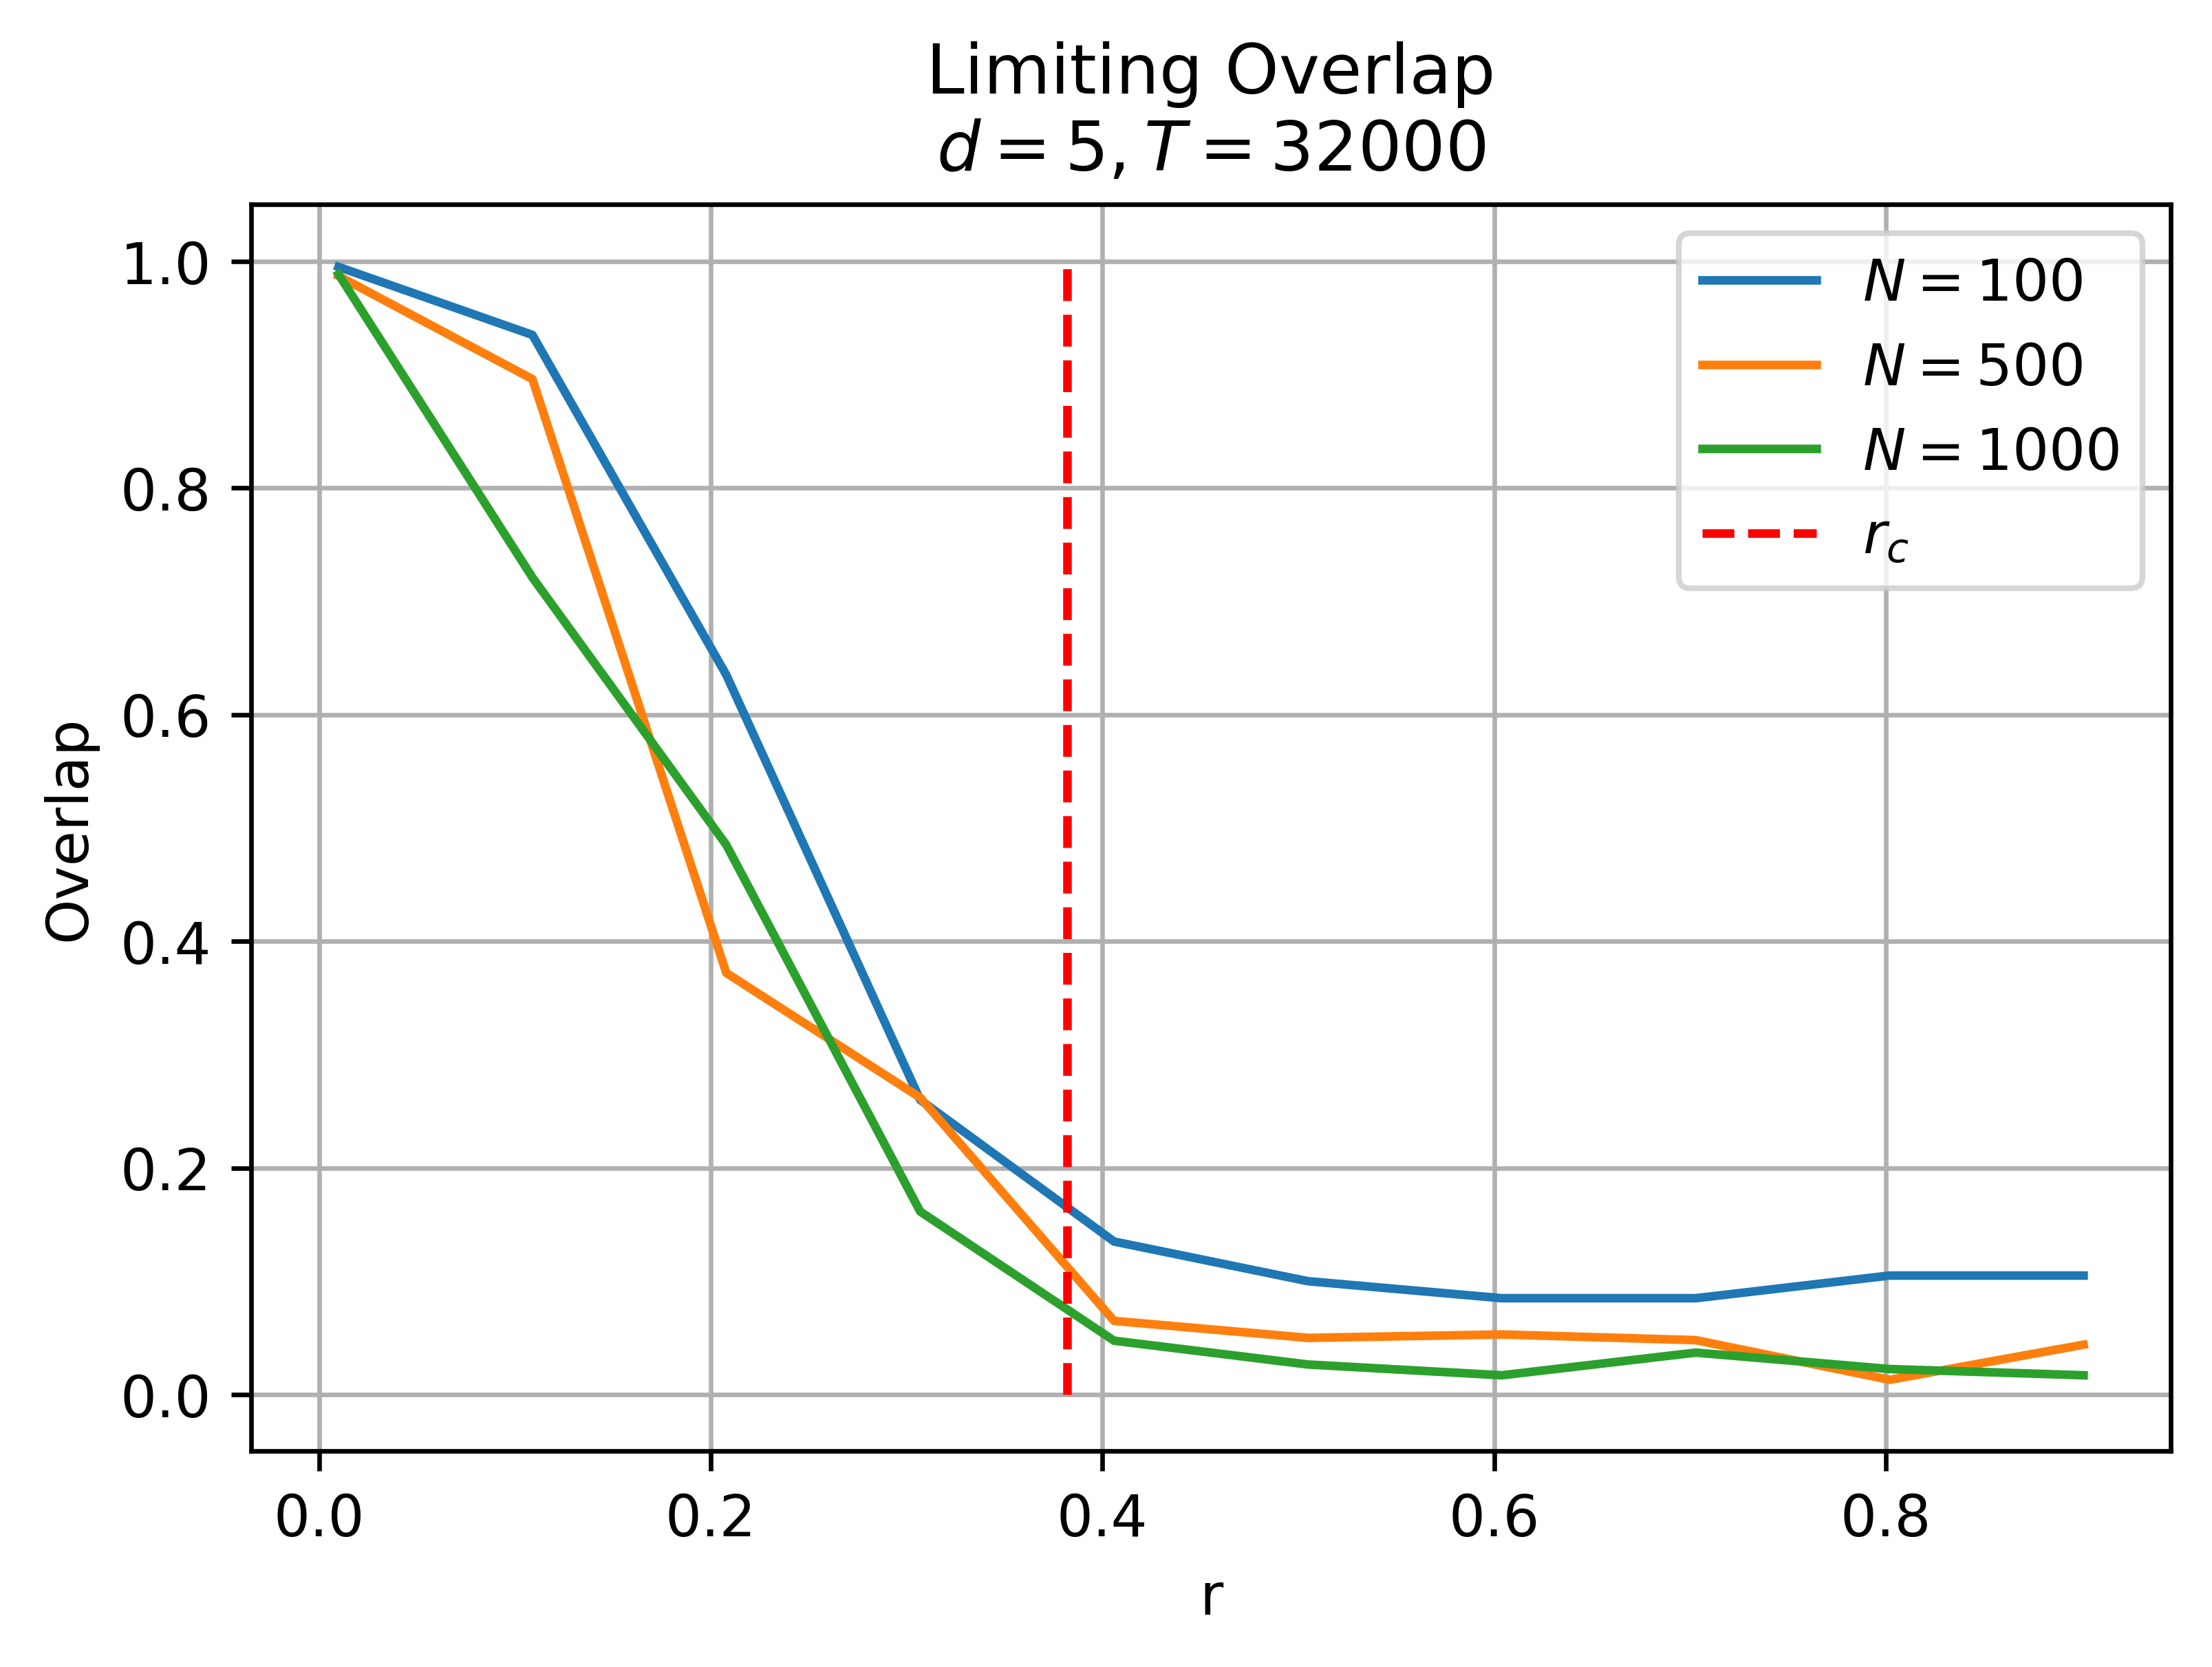

In [51]:
# Plot the limiting perfomance as a function of r
plt.figure(dpi=600)
labels = []
for i, N in enumerate(N_list):
    plt.plot(r_list, avg_list[i])
    labels.append(f'$N = {N}$')

# Plot the phase transition
plt.plot([r_c, r_c], [0, 1], 'r--', )
labels.append("$r_c$")

# Plot parameters
plt.legend(labels)
plt.xlabel("r")
plt.ylabel("Overlap")
plt.grid()
plt.title(f"Limiting Overlap\n$d = {d}, T = {T:d}$")

## Limiting performance for different values of r (Mixed)

In [5]:
# Problem parameters
d = 5
r_c = critical_ratio(d)
print(f'r_c = {r_c:.4f}')

# Simulation paramters
N = 1000        # Number of nodes
T = 32000       # Number of steps
num_xstar = 10  # Number of ground truths
num_graph = 10  # Number of graphs
num_exp = 1     # Number of experiments

# Values of n0 to be tested
n0_list = [0, 100, 1000]

# Values of r to be tested
r_list = np.linspace(0.01, 1, num=10, endpoint=False)

r_c = 0.3820


In [6]:
avg_list = []
for n0 in n0_list:
    # Generate all data for a given N
    print(f'{"-"*30} Running for n0 = {n0} {"-"*30}')
    Q = rplot_mixed(N, d, T, n0, r_list, num_xstar, num_graph, num_exp)
    
    # Save file
    path = '../data'
    stamp = datetime.now().strftime("%m_%d_%y_%H_%M_%S")
    filename = f'rplot_N_{N}_d_{d}_T_{T}_n0_{n0}_NRUN_{num_xstar}_{num_graph}_{num_exp}_TIME_{stamp}'
    np.save(f'{path}/{filename}', Q)
    
    # Compute average
    avg_list.append(np.average(Q, axis=(1,2,3)))

------------------------------ Running for n0 = 0 ------------------------------
Queueing jobs:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.07it/s]


Fetching results:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:31<00:00, 10.94it/s]

------------------------------ Running for n0 = 100 ------------------------------


Queueing jobs:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.69it/s]


Fetching results:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [08:49<00:00,  1.89it/s]

------------------------------ Running for n0 = 1000 ------------------------------


Queueing jobs:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.71it/s]


Fetching results:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:47<00:00,  3.47it/s]


Text(0.5, 1.0, 'Limiting Overlap\n$N = 1000, d = 5, T = 32000$')

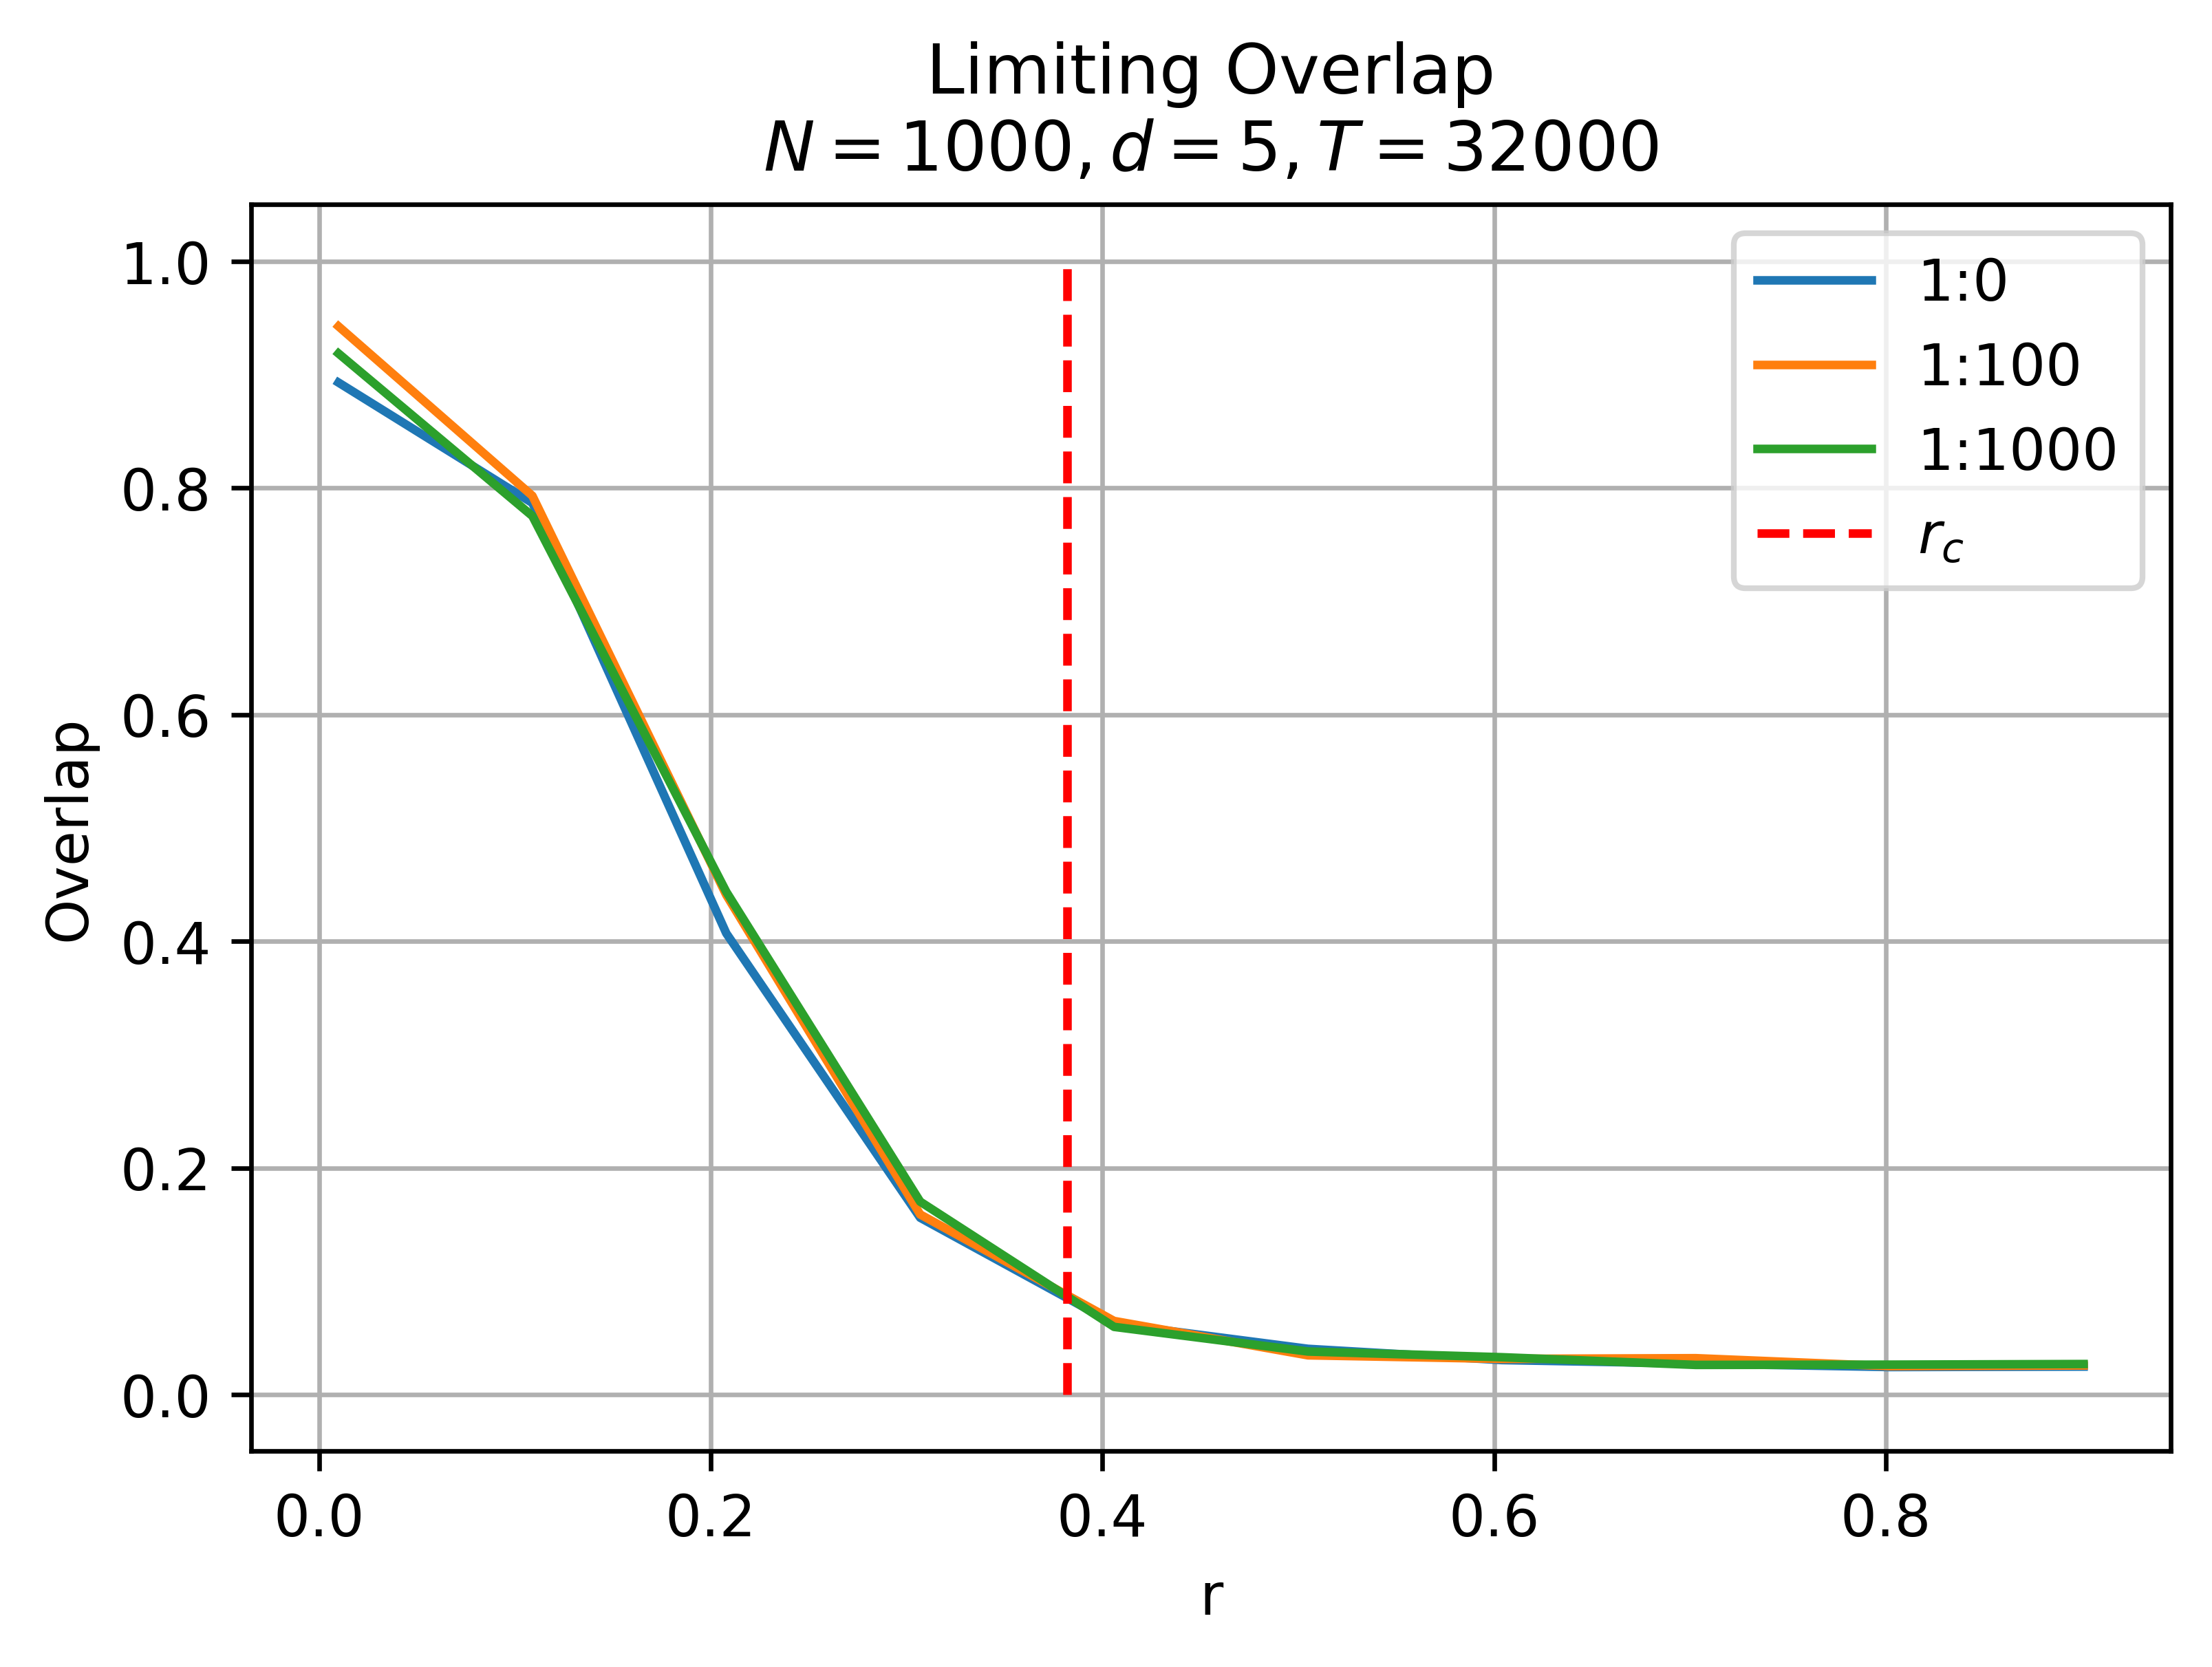

In [9]:
# Plot the limiting perfomance as a function of r
plt.figure(dpi=600)
labels = []
for i, n0 in enumerate(n0_list):
    plt.plot(r_list, avg_list[i])
    labels.append(f'1:{n0}')

# Plot the phase transition
plt.plot([r_c, r_c], [0, 1], 'r--', )
labels.append("$r_c$")

# Plot parameters
plt.legend(labels)
plt.xlabel("r")
plt.ylabel("Overlap")
plt.grid()
plt.title(f"Limiting Overlap\n$N = {N}, d = {d}, T = {T:d}$")